In [1]:
import importlib
import os
import sys
import tomllib
from pathlib import Path
from pprint import pprint

import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from monai.utils import set_determinism
from torch.utils.data import DataLoader

from src.utils import setup_dirs

sys.path.insert(0, "..")

In [2]:
root_dir = Path(os.getcwd()).parent
data_dir, log_dir, out_dir = setup_dirs(root_dir)
data_dir = data_dir / "ACDC" / "database"

with open(root_dir / "config.toml", "rb") as file:
    config = tomllib.load(file)

pprint(config)
set_determinism(seed=config["hyperparameters"]["seed"])

{'hyperparameters': {'augment': True,
                     'batch_size': 8,
                     'epochs': 150,
                     'learning_rate': 1e-06,
                     'percentage_data': 1.0,
                     'seed': 42,
                     'spatial_dimensions': 3,
                     'validation_split': 0.8}}


In [3]:


importlib.reload(sys.modules["src.transforms"])
importlib.reload(sys.modules["src.datasets.acdc_dataset"])
from src.transforms.transforms import get_transforms
from src.datasets.acdc_dataset import ACDCDataset

train_transforms, val_transforms = get_transforms(percentage_slices=0.8)
train_transform_no_aug, _ = get_transforms(percentage_slices=1.0, augment=False)
train_data = ACDCDataset(data_dir=data_dir / "training", transform=train_transforms)
train_data_no_aug = ACDCDataset(data_dir=data_dir / "training", transform=train_transform_no_aug)

check_dataloader = DataLoader(train_data, batch_size=8, shuffle=False)
check_dataloader_no_aug = DataLoader(train_data_no_aug, batch_size=8, shuffle=False)

print(len(check_dataloader.dataset))


100


In [4]:
# for data in check_dataloader:
#     ed = data['end_diastole']
#     print(ed.shape)

data = next(iter(check_dataloader))
for key, image in data.items():
    data[key] = image.permute(0, 1, 3, 4, 2)
image, label = data['image'], data['label']
print(image.shape)
# image = image.permute(0, 1, 3, 4, 2)
# print(image.shape)


torch.Size([8, 1, 224, 224, 16])


In [10]:
for batch in check_dataloader:
    print(batch["image"].shape)
    print(batch["label"].shape)


torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])
torch.Size([8, 1, 16, 224, 224])


[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:109] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

Slices 10
Slices 10
Slices 10
Slices 10
Slices 10
Slices 11
Slices 10
Slices 10


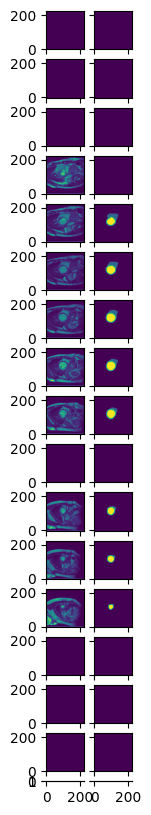

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

check_data = next(iter(check_dataloader))
check_data_no_aug = next(iter(check_dataloader_no_aug))

image, label = check_data["image"][0][0], check_data["label"][0][0]
image_no_aug, label_no_aug = check_data_no_aug["image"][0][0], check_data_no_aug["label"][0][0]

slices = 16
total_slices = image.shape[0]
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(slices + 1, 2), axes_pad=0.1)

images = []
for i in range(slices):
    # images.append(image_no_aug[i, ...])
    # images.append(label_no_aug[i, ...])
    # images.append(image[(10 + i) % total_slices, ...])
    # images.append(label[(10 + i) % total_slices, ...])
    images.append(image[i, ...])
    images.append(label[i, ...])

for ax, image in zip(grid, images):
    ax.imshow(image, origin="lower")

plt.show()


In [ ]:
data = next(iter(check_dataloader))
image, label = data['end_diastole'], data['end_diastole_label']
print(image.shape, label.shape)

In [99]:
patient = "patient001"
patient_dir = data_dir / "training" / patient

full_image = nib.load(patient_dir / f"{patient}_4d.nii.gz")
print(full_image)


In [ ]:
print(full_image.header.get_zooms())
print(full_image.header.get_xyzt_units())


In [ ]:
end_diastole = nib.load(patient_dir / f"{patient}_frame01.nii.gz")
end_diastole = end_diastole.get_fdata(dtype=np.float32)

print(end_diastole.shape)
print(end_diastole[0].shape)
print(end_diastole[:, :, 0].shape)


In [ ]:
width = end_diastole.shape[0]
height = end_diastole.shape[1]
slices = end_diastole.shape[2]

fig, axs = plt.subplots(3, 4, figsize=[10, 10])
for idx in range(slices):
    axs.flat[idx].imshow(end_diastole[:, :, idx], cmap='gray')
    axs.flat[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# I want to check that the frames that are separately being loaded are the same as within the 4D image
full_4d_volume = full_image.get_fdata(dtype=np.float32)
first_frame = full_4d_volume[:, :, :, 0]
assert np.allclose(first_frame, end_diastole)

# Note that despite being named frame01 it is actually frame00 - the literal first time frame, zero indexed